# Laboratorio 3

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## 1. Analisis Exploratorio

In [38]:
data = pd.read_csv('./digit-recognizer/train.csv')

data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
data.shape

(42000, 785)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [41]:
label_counts = {}
for x in data["label"]:
    if x not in label_counts:
        label_counts[x] = 1
    else:
        label_counts[x] += 1

print(label_counts)

{1: 4684, 0: 4132, 4: 4072, 7: 4401, 3: 4351, 5: 3795, 8: 4063, 9: 4188, 2: 4177, 6: 4137}


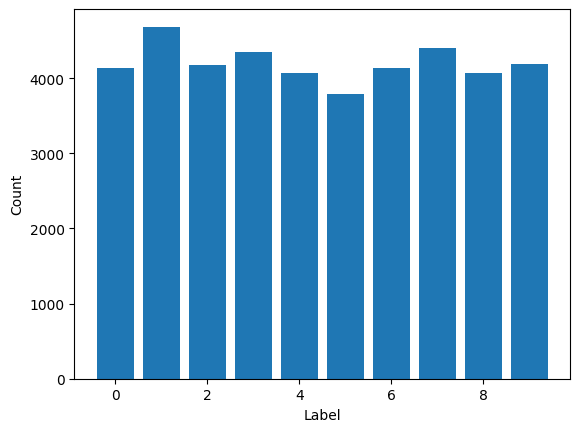

In [42]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Al observar la grafica del conteo de labels se puede observar que el dataset se encuentra balanceado por lo que no es necesario realizar un balanceo de datos y se puede continuar con la clasificacion. 

In [43]:
full_train = data.copy()

## 2. Modelo de Redes Neuronales Simples

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mejores hiperparámetros: {'hidden_layer_sizes': (50,)}
Accuracy: 94.43%


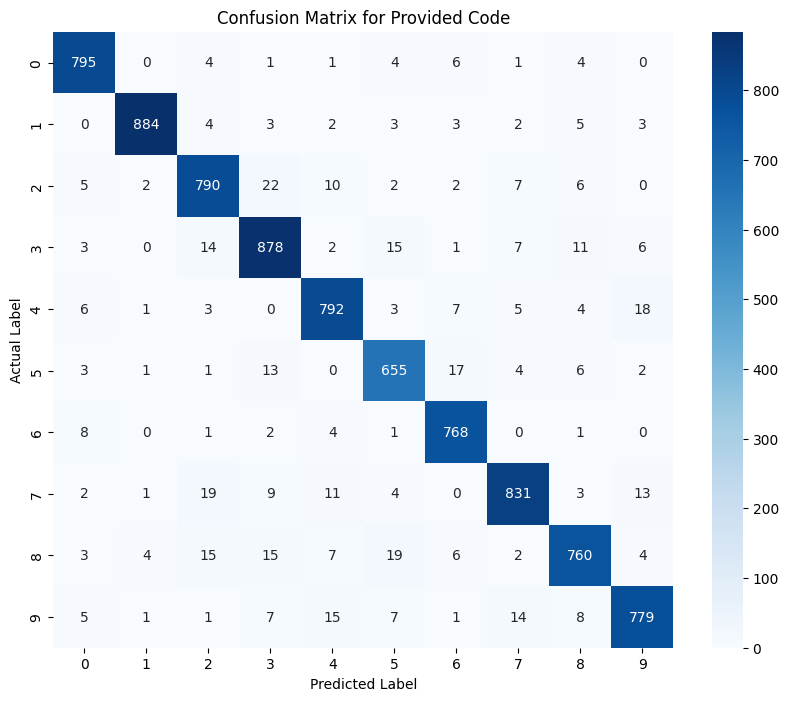

In [44]:
y = data["label"]
X = data.drop("label", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid_1 = {"hidden_layer_sizes":[(15,), (25,), (50,)]}

# Creación de la red neuronal

# Aquí estamos creando una red neuronal con una capa oculta de 5 neuronas
mlp = MLPClassifier(random_state=42)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid_1, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Provided Code')
plt.show()

El modelo de red neuronal simple tuvo un accuracy de 0.89 por lo que variando algunos parametros se puede mejor la precision. Tambien al observar la matriz de confusion, se puede ver que el modelo tiene problemas para clasificar los numeros 4 y 9, al igual que 9 y 7. Estos presentan ser los errores mas comunes del modelo y el numero 1 es el que mejor clasifica.

## 3. Modelo de Deep Learning

In [71]:
from keras.utils import to_categorical

# Separar las etiquetas y las imágenes
X_train_normalize = X_train.values / 255.0
X_test_normalize = X_test.values / 255.0
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test) 

# Cambiar la forma de los datos de las imágenes
images = X_train_normalize.reshape(-1, 28, 28, 1)
images_test = X_test_normalize.reshape(-1, 28, 28, 1)

# Codificar las etiquetas en formato one-hot

In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 clases de salida

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [73]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def create_model(optimizer='adam', filters=32):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=2)
random_search_results = random_search.fit(images, y_train_one_hot)


C:\Users\archi\AppData\Local\Temp\ipykernel_27968\923456237.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Epoch 1/10
420/420 [==============================] - 8s 17ms/step - loss: 0.2679 - accuracy: 0.9240
Epoch 2/10
420/420 [==============================] - 7s 17ms/step - loss: 0.0802 - accuracy: 0.9769
Epoch 3/10
420/420 [==============================] - 7s 17ms/step - loss: 0.0503 - accuracy: 0.9854
Epoch 4/10
420/420 [==============================] - 8s 18ms/step - loss: 0.0367 - accuracy: 0.9888
Epoch 5/10
420/420 [==============================] - 7s 17ms/step - loss: 0.0262 - accuracy: 0.9919
Epoch 6/10
420/420 [==============================] - 7s 16ms/step - loss: 0.0169 - accuracy: 0.9952
Epoch 7/10
420/420 [==============================] - 8s 18ms/step - loss: 0.0152 - accuracy: 0.9951
Epoch 8/10
420/420 [==============================] - 7s 18ms/step - loss: 0.0106 - accuracy: 0.9968
Epoch 9/10
420/420 [==============================] - 8s 18ms/step - loss: 0.0089 - accuracy: 0.9975
Epoch 10/10
105/105 [==============================] - 1s 6ms/step - loss: 0.0710 - accurac

In [75]:
# Usando los hiperparámetros obtenidos del proceso de afinación
best_params = random_search_results.best_params_

model = create_model(optimizer=best_params['optimizer'], filters=best_params['filters'])
history = model.fit(images, y_train_one_hot, batch_size=best_params['batch_size'], epochs=best_params['epochs'], validation_split=0.2

SyntaxError: incomplete input (4011519440.py, line 5)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Accuracy on test data: {test_accuracy * 100:.2f}%")

## 4. Modelo Cualquiera

##### Random forest

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Mejores hiperparámetros: {'n_estimators': 200}
Accuracy: 96.36%


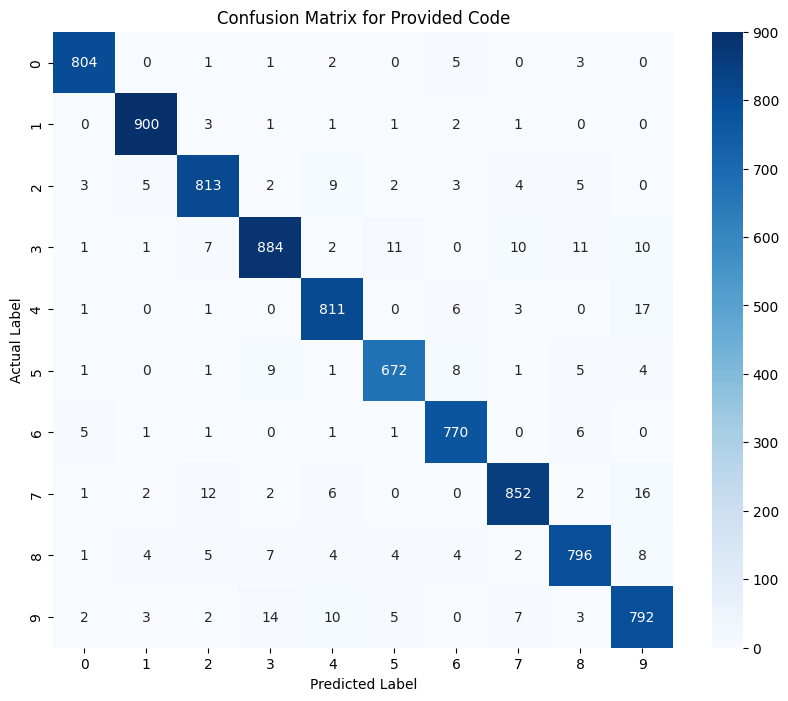

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Executing the provided code

# Cargando el conjunto de datos
param_grid_2 = {
    'n_estimators': [50, 100, 200]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_2, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculando y mostrando la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Compute the confusion matrix for the provided code's predictions
conf_mat_2 = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_2, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Provided Code')
plt.show()



El modelo tuvo un accuracy de 96.28%. Para este modelo, en la matriz de confusión, se observa como se tuvieron muy buenos resultados y los errores se  encuentran en números que podrían tener caracteristicas similares entre ellos (4, 9), (9,7). Esto podría deberse a la similitud entre estos números en su forma, esto tambien depende de la calidad de las imagenes utilizadas para el entrenamiento. Para este modelo, las mejores calsificaciones las obtiene el número 1 mientras que el menor lo obtuvo el número 5. 

## 5. Prueba del mejor modelo